In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import fsps

In [4]:
from provabgs import util as UT
from provabgs import models as Models

In [5]:
m_nmf = Models.NMF(burst=False, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [6]:
t_lb_true = np.linspace(0., 13.7, 50000)
_sfh = np.dot(np.array([0.5, 0.25, 0.15, 0.1]), np.array([m_nmf._sfh_basis[i](t_lb_true) for i in range(4)]))
sfh_true = _sfh / np.trapz(_sfh, t_lb_true)

In [7]:
t_lb_hr = UT.trapz_rebin(t_lb_true, t_lb_true, edges=t_lb_true)
sfh_hr = UT.trapz_rebin(t_lb_true, sfh_true, edges=t_lb_true)

In [8]:
lr_edges = np.linspace(0., 13.7, 100)
t_lb_lr = UT.trapz_rebin(t_lb_true, t_lb_true, edges=lr_edges)
sfh_lr = UT.trapz_rebin(t_lb_true, sfh_true, edges=lr_edges)

In [9]:
rt_edges = np.concatenate([np.array([0]), 0.5 * (m_nmf._nmf_t_lb_sfh[1:] + m_nmf._nmf_t_lb_sfh[:-1]), np.array([13.7])])
t_lb_rt = UT.trapz_rebin(t_lb_true, t_lb_true, edges=rt_edges)
sfh_rt = UT.trapz_rebin(t_lb_true, sfh_true, edges=rt_edges)

In [10]:
def make_bins(midpoints, make_rhs=False):
    """ A general function for turning an array of bin midpoints into an
    array of bin left hand side positions and bin widths. Splits the
    distance between bin midpoints equally in linear space.
    Parameters
    ----------
    midpoints : numpy.ndarray
        Array of bin midpoint positions
    make_rhs : bool
        Whether to add the position of the right hand side of the final
        bin to bin_lhs, defaults to false.
    """

    bin_widths = np.zeros_like(midpoints)

    if make_rhs:
        bin_lhs = np.zeros(midpoints.shape[0]+1)
        bin_lhs[0] = midpoints[0] - (midpoints[1]-midpoints[0])/2
        bin_widths[-1] = (midpoints[-1] - midpoints[-2])
        bin_lhs[-1] = midpoints[-1] + (midpoints[-1]-midpoints[-2])/2
        bin_lhs[1:-1] = (midpoints[1:] + midpoints[:-1])/2
        bin_widths[:-1] = bin_lhs[1:-1]-bin_lhs[:-2]

    else:
        bin_lhs = np.zeros_like(midpoints)
        bin_lhs[0] = midpoints[0] - (midpoints[1]-midpoints[0])/2
        bin_widths[-1] = (midpoints[-1] - midpoints[-2])
        bin_lhs[1:] = (midpoints[1:] + midpoints[:-1])/2
        bin_widths[:-1] = bin_lhs[1:]-bin_lhs[:-1]

    return bin_lhs, bin_widths

age_sampling = np.arange(6., np.log10(13.7) + 9., 0.1)

# Set up edge positions for age bins for stellar + nebular models.
age_bins = 10**make_bins(age_sampling, make_rhs=True)[0]
age_bins[0] = 0.
age_bins[-1] = 10**9*13.7

In [11]:
lg_edges = age_bins/1e9

t_lb_lg = UT.trapz_rebin(t_lb_true, t_lb_true, edges=lg_edges)
sfh_lg = UT.trapz_rebin(t_lb_true, sfh_true, edges=lg_edges)

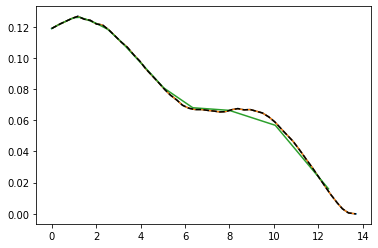

In [12]:
plt.plot(t_lb_hr, sfh_hr)
plt.plot(t_lb_lr, sfh_lr)
plt.plot(t_lb_lg, sfh_lg)

plt.plot(t_lb_true, sfh_true, c='k', ls='--')

In [13]:
sps = fsps.StellarPopulation()
print(sps.libraries)

(b'mist', b'miles', b'DL07  ')


In [14]:
def spectrum(tlb, sfh, edges):
    dt = np.diff(edges)
    mtot = 0.
    for i, _tlb, _sfh, _dt in zip(range(len(tlb)), tlb, sfh, dt): 
        m = _dt * _sfh
        w, ssp = sps.get_spectrum(tage=_tlb)
        if i == 0: 
            spec = m * ssp
        else: 
            spec += m * ssp
        mtot += m
    return w, spec, mtot

In [15]:
w, spec_hr, mtot_hr = spectrum(t_lb_hr, sfh_hr, t_lb_true)

In [16]:
_, spec_lr, mtot_lr = spectrum(t_lb_lr, sfh_lr, lr_edges)

In [17]:
_, spec_lg, mtot_lg = spectrum(t_lb_lg, sfh_lg, lg_edges)

In [18]:
_, spec_rt, mtot_rt = spectrum(t_lb_rt, sfh_rt, rt_edges)

(1000.0, 10000.0)

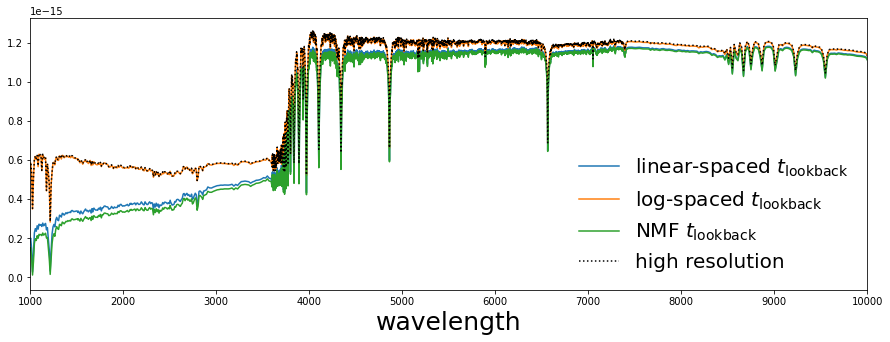

In [19]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w, spec_lr, label=r'linear-spaced $t_{\rm lookback}$')
sub.plot(w, spec_lg, label=r'log-spaced $t_{\rm lookback}$')
sub.plot(w, spec_rt, label=r'NMF $t_{\rm lookback}$')
sub.plot(w, spec_hr, c='k', ls=':', label='high resolution')
sub.legend(loc='lower right', frameon=False, fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)

(0.0, 0.1)

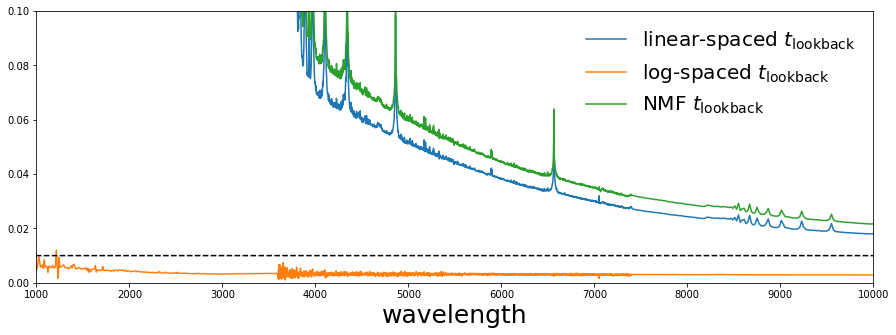

In [20]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w, 1-spec_lr/spec_hr, label=r'linear-spaced $t_{\rm lookback}$')
sub.plot(w, 1-spec_lg/spec_hr, label=r'log-spaced $t_{\rm lookback}$')
sub.plot(w, 1-spec_rt/spec_hr, label=r'NMF $t_{\rm lookback}$')
sub.plot(w, 0.01*np.ones(len(w)), c='k', ls='--')
sub.legend(loc='upper right', frameon=False, fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)
sub.set_ylim(0., 0.1)

# for a quiescent galaxy

In [21]:
t_lb_true = np.linspace(0., 13.7, 50000)
_sfh = np.dot(np.array([0.1, 0.15, 0.25, 0.5]), np.array([m_nmf._sfh_basis[i](t_lb_true) for i in range(4)]))
sfh_true = _sfh / np.trapz(_sfh, t_lb_true)

In [22]:
t_lb_hr = UT.trapz_rebin(t_lb_true, t_lb_true, edges=t_lb_true)
sfh_hr = UT.trapz_rebin(t_lb_true, sfh_true, edges=t_lb_true)

In [23]:
lr_edges = np.linspace(0., 13.7, 100)
t_lb_lr = UT.trapz_rebin(t_lb_true, t_lb_true, edges=lr_edges)
sfh_lr = UT.trapz_rebin(t_lb_true, sfh_true, edges=lr_edges)

In [24]:
rt_edges = np.concatenate([np.array([0]), 0.5 * (m_nmf._nmf_t_lb_sfh[1:] + m_nmf._nmf_t_lb_sfh[:-1]), np.array([13.7])])
t_lb_rt = UT.trapz_rebin(t_lb_true, t_lb_true, edges=rt_edges)
sfh_rt = UT.trapz_rebin(t_lb_true, sfh_true, edges=rt_edges)

In [25]:
lg_edges = age_bins/1e9
t_lb_lg = UT.trapz_rebin(t_lb_true, t_lb_true, edges=lg_edges)
sfh_lg = UT.trapz_rebin(t_lb_true, sfh_true, edges=lg_edges)

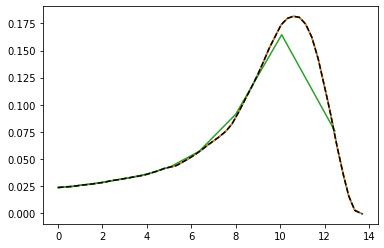

In [26]:
plt.plot(t_lb_hr, sfh_hr)
plt.plot(t_lb_lr, sfh_lr)
plt.plot(t_lb_lg, sfh_lg)

plt.plot(t_lb_true, sfh_true, c='k', ls='--')

In [27]:
w, spec_hr, mtot_hr = spectrum(t_lb_hr, sfh_hr, t_lb_true)
_, spec_lr, mtot_lr = spectrum(t_lb_lr, sfh_lr, lr_edges)
_, spec_lg, mtot_lg = spectrum(t_lb_lg, sfh_lg, lg_edges)
_, spec_rt, mtot_rt = spectrum(t_lb_rt, sfh_rt, rt_edges)

(1000.0, 10000.0)

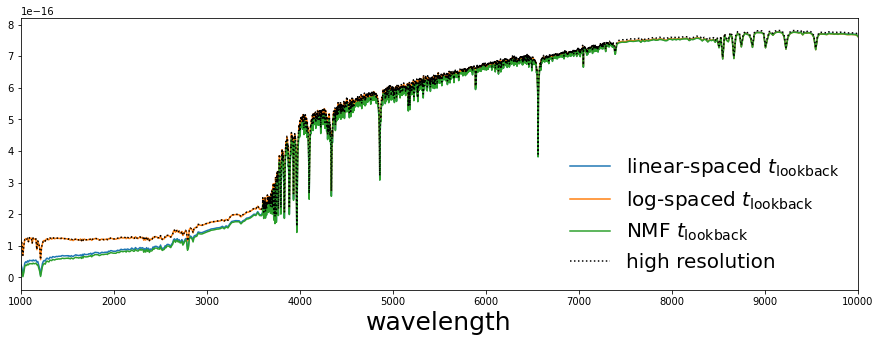

In [28]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w, spec_lr, label=r'linear-spaced $t_{\rm lookback}$')
sub.plot(w, spec_lg, label=r'log-spaced $t_{\rm lookback}$')
sub.plot(w, spec_rt, label=r'NMF $t_{\rm lookback}$')
sub.plot(w, spec_hr, c='k', ls=':', label='high resolution')
sub.legend(loc='lower right', frameon=False, fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)

(0.0, 0.1)

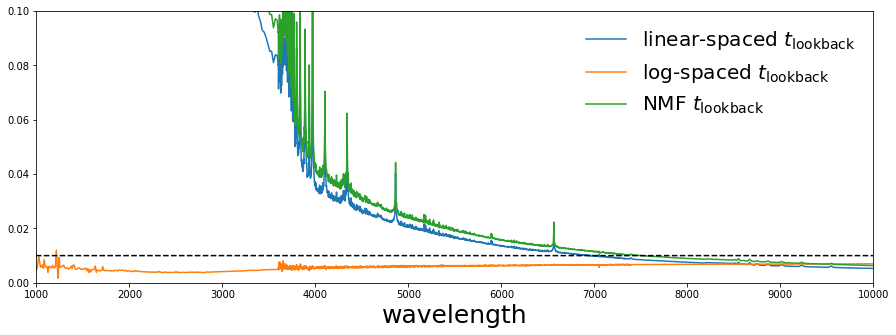

In [29]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(w, 1-spec_lr/spec_hr, label=r'linear-spaced $t_{\rm lookback}$')
sub.plot(w, 1-spec_lg/spec_hr, label=r'log-spaced $t_{\rm lookback}$')
sub.plot(w, 1-spec_rt/spec_hr, label=r'NMF $t_{\rm lookback}$')
sub.plot(w, 0.01*np.ones(len(w)), c='k', ls='--')
sub.legend(loc='upper right', frameon=False, fontsize=20)
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(1e3, 1e4)
sub.set_ylim(0., 0.1)